In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import deque
import torch.optim as optim

## 1.定义算法
### 1.1 建立Actor网络、Critic网络和OU噪声类

In [14]:
class Actor(nn.Module):
    def __init__(self, n_states, n_actions, hidden_dim, init_w=3e-3):
        '''
        actor 模型的结构定义
        Args:
            n_states (int): 输入状态的维度
            n_actions (int): 可执行动作的数量
            hidden_dim (int): 隐含层数量
            init_w (float, optional): 均匀分布初始化权重的范围
        '''
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(n_states, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, n_actions)

        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x


class Critic(nn.Module):
    def __init__(self, n_states, n_actions, hidden_dim, init_w=3e-3):
        '''
        critic 模型的结构定义
        Args:
            n_states (int): 输入状态的维度
            n_actions (int): 可执行动作的数量
            hidden_dim (int): 隐含层数量
            init_w (float, optional): 均匀分布初始化权重的范围
        '''
        super(Critic, self).__init__()

        self.linear1 = nn.Linear(n_states + n_actions, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        # 随机初始化为较小的值
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)

    def forward(self, state, action):
        # 按维数1拼接
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x


class OUNoise(object):
    '''
    构造 Ornstein–Uhlenbeck 噪声的类
    '''

    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        '''
        初始化输入参数
        Args:
            action_space (Union[gym.spaces.box.Box, gym.spaces.discrete.Discrete]): env 中的 action_space
            mu (float, optional): 噪声均值
            theta (float, optional): 系统对噪声的扰动程度，theta 越大，噪声扰动越小
            max_sigma (float, optional): 最大 sigma，用于更新衰变 sigma 值
            min_sigma (float, optional): 最小 sigma，用于更新衰变 sigma 值
            decay_period (int, optional): 衰变周期
        '''
        self.mu = mu
        self.theta = theta
        self.sigma = max_sigma
        self.max_sigma = max_sigma
        self.min_sigma = min_sigma
        self.decay_period = decay_period
        self.n_actions = action_space.shape[0]  # env环境中可执行动作的数量
        self.low = action_space.low  # env环境中动作取值的最小值
        self.high = action_space.high  # env环境中动作取值的最大值
        self.reset()

    def reset(self):
        '''
        重置噪声
        '''
        self.obs = np.ones(self.n_actions) * self.mu  # reset the noise

    def evolve_obs(self):
        '''
        更新噪声
        Returns:
            返回更新后的噪声值
        '''
        x = self.obs
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.n_actions)  # Ornstein–Uhlenbeck process
        self.obs = x + dx
        return self.obs

    def get_action(self, action, t=0):
        '''
        根据输入的动作，输出加入 OU 噪声后的动作
        Args:
            action (array): 输入的动作值
            t (int, optional): 当前环境已执行的帧数

        Returns:
            action (float): 返回加入 OU 噪声后的动作
        '''
        ou_obs = self.evolve_obs()
        ## 根据env进程（t），通过设定的衰变周期（decay_period），进行更新衰变的sigma值
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_obs, self.low, self.high)  # add noise to action

### 1.2 定义经验回放

In [15]:
class ReplayBufferQue:
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=self.capacity)
    def push(self,transitions):
        '''_summary_
        Args:
            trainsitions (tuple): _description_
        '''
        self.buffer.append(transitions)
    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        if sequential: # sequential sampling
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else:
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
    def clear(self):
        self.buffer.clear()
    def __len__(self):
        return len(self.buffer)

### 1.3 DDPG_HER算法

In [16]:
class DDPG_HER:
    def __init__(self, cfg):
        '''
        构建智能体
        Args:
            cfg (class): 超参数类 AlgoConfig
        '''
        self.n_states = cfg.n_states
        self.n_actions = cfg.n_actions
        self.states_dim = cfg.n_states * 2
        self.actions_dim = cfg.n_actions
        self.action_space = cfg.action_space  # env 中的 action_space
        self.ou_noise = OUNoise(self.action_space)  # 实例化 构造 Ornstein–Uhlenbeck 噪声的类
        self.batch_size = cfg.batch_size
        self.gamma = cfg.gamma
        self.tau = cfg.tau
        self.sample_count = 0  # 记录采样动作的次数
        self.update_flag = False  # 标记是否更新网络
        self.device = torch.device(cfg.device)
        self.critic = Critic(self.states_dim, self.actions_dim, hidden_dim=cfg.critic_hidden_dim).to(self.device)
        self.target_critic = Critic(self.states_dim, self.actions_dim, hidden_dim=cfg.critic_hidden_dim).to(self.device)
        self.actor = Actor(self.states_dim, self.actions_dim, hidden_dim=cfg.actor_hidden_dim).to(self.device)
        self.target_actor = Actor(self.states_dim, self    .actions_dim, hidden_dim=cfg.actor_hidden_dim).to(self.device).to(
            self.device)
        ## 将 critc 网络的参数赋值给target critic 网络
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        ## 将 actor 网络的参数赋值给target actor 网络
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=cfg.critic_lr)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=cfg.actor_lr)
        self.memory = ReplayBufferQue(cfg.buffer_size)

    def sample_action(self, state):
        '''
        根据输入的状态采样动作
        Args:
            state (array): 输入的状态

        Returns:
            action (float): 根据状态采样后的动作
        '''
        self.sample_count += 1
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        action_tanh = self.actor(state)  # action_tanh is in [-1, 1]
        # convert action_tanh to action in the original action space
        action_scale = torch.FloatTensor((self.action_space.high - self.action_space.low) / 2.).to(self.device)
        action_bias = torch.FloatTensor((self.action_space.high + self.action_space.low) / 2.).to(self.device)
        action = action_scale * action_tanh + action_bias
        action = action.cpu().detach().numpy()[0]
        # add noise to action
        action = self.ou_noise.get_action(action, self.sample_count)
        return action

    @torch.no_grad()
    def predict_action(self, state):
        '''
        根据输入的状态预测下一步的动作
        Args:
            state (array):  输入的状态

        Returns:
            action (float): 根据状态采样后的动作
        '''
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        action_tanh = self.actor(state)  # action_tanh is in [-1, 1]
        # convert action_tanh to action in the original action space
        action_scale = torch.FloatTensor((self.action_space.high - self.action_space.low) / 2.).to(self.device)
        action_bias = torch.FloatTensor((self.action_space.high + self.action_space.low) / 2.).to(self.device)
        action = action_scale * action_tanh + action_bias
        action = action.cpu().detach().numpy()[0]
        return action

    def update(self):
        ## 当经验回放池中的数量小于 batch_size 时，直接返回不更新
        if len(self.memory) < self.batch_size:  # when memory size is less than batch size, return
            return
        else:
            if not self.update_flag:
                print("Begin to update!")
                self.update_flag = True
        ## 从经验回放池中采样 batch_size 个样本
        state, action, reward, next_state, done = self.memory.sample(self.batch_size)
        ## 将状态、动作等 array 转为 tensor
        state = torch.FloatTensor(np.array(state)).to(self.device)
        next_state = torch.FloatTensor(np.array(next_state)).to(self.device)
        action = torch.FloatTensor(np.array(action)).to(self.device)
        reward = torch.FloatTensor(reward).unsqueeze(1).to(self.device)
        done = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(self.device)
        ## 输入状态及通过 actor 网络 根据该状态输出的动作，计算 critic 网络输出的价值，类似于DQN中的q-value
        policy_loss = self.critic(state, self.actor(state))
        ## 计算均值作为 critic 网络的损失
        policy_loss = -policy_loss.mean()
        ## 根据下一个 timestamp 的状态用 target_actor 网络输出目标动作
        next_action = self.target_actor(next_state)
        ## 输入下一个 timestamp 的状态及目标动作，计算 target_critc 网络输出的目标价值
        target_value = self.target_critic(next_state, next_action.detach())
        ## 根据真实奖励更新目标价值
        expected_value = reward + (1.0 - done) * self.gamma * target_value
        expected_value = torch.clamp(expected_value, -np.inf, np.inf)
        ## 输入状态和动作，用 critic 网络计算预估的价值
        value = self.critic(state, action)
        ## 将 critic 网络输出的价值和 target_critic输出并更新后的价值通过MSE进行损失计算
        value_loss = nn.MSELoss()(value, expected_value.detach())
        ## 更新 actor 网络参数
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()
        ## 更新 critic 网络参数
        self.critic_optimizer.zero_grad()
        value_loss.backward()
        self.critic_optimizer.step()
        ## 通过软更新的方法，缓慢更新 target critic 网络的参数
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - self.tau) +
                param.data * self.tau
            )
        ## 通过软更新的方法，缓慢更新 target actor 网络的参数
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - self.tau) +
                param.data * self.tau
            )

    def save_model(self, fpath):
        '''
        保存模型
        Args:
            fpath (str): 模型存放路径
        '''
        from pathlib import Path
        # create path

        Path(fpath).mkdir(parents=True, exist_ok=True)
        torch.save(self.actor.state_dict(), f"{fpath}/actor_checkpoint.pt")

    def load_model(self, fpath):
        '''
        根据模型路径导入模型
        Args:
            fpath (str): 模型路径
        '''
        actor_ckpt = torch.load(f"{fpath}/actor_checkpoint.pt", map_location=self.device)
        self.actor.load_state_dict(actor_ckpt)


## 2.模型训练与测试

### 2.1 定义奖励计算函数和目标生成函数

In [17]:
def calcu_reward(new_goal, state, action):
    # direcly use observation as goal
    goal_cos, goal_sin, goal_thdot = new_goal[0], new_goal[1], new_goal[2]
    cos_th, sin_th, thdot = state[0], state[1], state[2]
    costs = angle_normalize(np.arccos(goal_cos) - np.arccos(cos_th)) ** 2 + 0.1 * (goal_thdot - thdot) ** 2#+ (goal_sin - sin_th) ** 2 
    reward = -costs
    return reward

def generate_goals(i, episode_cache, sample_num, sample_range = 200):
    '''
    Input: current steps, current episode transition's cache, sample number
    Return: new goals sets
    notice here only "future" sample policy
    '''
    end = (i+sample_range) if i+sample_range < len(episode_cache) else len(episode_cache)
    epi_to_go = episode_cache[i:end]
    if len(epi_to_go) < sample_num:
        sample_trans = epi_to_go
    else:
        sample_trans = random.sample(epi_to_go, sample_num)
    return [np.array(trans[3][:3]) for trans in sample_trans]#episode_cache.append((o,a,r,o2))

def angle_normalize(x):
    return ((x + np.pi) % (2 * np.pi)) - np.pi

### 2.2 训练函数与测试函数

In [24]:
def train(cfg, env, agent):
    print("开始训练！")
    rewards = [] # 记录所有回合的奖励
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # reward per episode
        ep_step = 0
        episode_cache = []
        HER_SAMPLE_NUM = cfg.her_sample_num
        update_every = cfg.update_every
        state = env.reset()  # 环境状态
        # 随机构造目标
        np.random.seed(cfg.seed)
        costheta = np.random.rand()
        sintheta = np.sqrt(1-costheta**2)
        w = 2 * np.random.rand()
        goal = np.array([costheta,sintheta,w])
        state = np.concatenate((state, goal)) # 结合环境状态和目标，构造新状态
        for _ in range(cfg.max_steps):
            ep_step += 1
            action = agent.sample_action(state)  # sample action
            next_state, reward, terminated, _ = env.step(
                action)  # update env and return transitions under new_step_api of OpenAI Gym
            next_state = np.concatenate((next_state, goal)) # 结合下一时间步环境状态和目标，构造新下一时间步状态
            reward = calcu_reward(goal, state, action) # 根据目标、状态、动作计算HER奖励
            episode_cache.append((state, action, reward, next_state)) # 缓存transitions，便于事后经验回放
            agent.memory.push((state, action, reward,
                               next_state, terminated))  # 将transitions存入经验缓存池
            
            state = next_state  # update next state for env
            ep_reward += reward  #
            if terminated:
                break

        # Hindsight replay: Important operation of HER
        for i, transition in enumerate(episode_cache):
            new_goals = generate_goals(i, episode_cache, HER_SAMPLE_NUM) # 根据future方法构造新目标
            for new_goal in new_goals:
                state, action = transition[0], transition[1] # 从transition提取具有目标的状态和动作
                reward = calcu_reward(new_goal, state, action) # 根据新目标、状态、动作计算奖励值
            
                state, new_state = transition[0][:3], transition[3][:3] # 从transition提取不包含目标的状态和下一时间步状态
                state = np.concatenate((state, new_goal)) # 结合环境状态和生成的新目标，构造新状态
                new_state = np.concatenate((new_state, new_goal)) # 结合下一时间步环境状态和生成的新目标，构造新下一时间步状态
                agent.memory.push((state, action, reward, new_state, False)) # 将新的transition存入经验缓存池


        for _ in range(update_every):
            agent.update()  # update agent
        rewards.append(ep_reward)
    print("完成训练！")
    return {'rewards':rewards}
def test(cfg, env, agent):
    print("开始测试！")
    rewards = [] # 记录所有回合的奖励
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # reward per episode
        ep_step = 0
        ep_frames = []
        state = env.reset(seed = cfg.seed)  # 环境状态
        # 随机构造目标
        costheta = np.random.rand()
        sintheta = np.sqrt(1-costheta**2)
        w = 2 * np.random.rand()
        goal = np.array([costheta,sintheta,w])
        state = np.concatenate((state, goal)) # 结合环境状态和目标，构造新状态
        for _ in range(cfg.max_steps):
            ep_step += 1
            if cfg.render and cfg.render_mode == 'rgb_array': # 用于可视化
                frame = env.render()[0]
                ep_frames.append(frame)
            action = agent.predict_action(state)  # sample action
            next_state, reward, terminated, _ = env.step(
                action)  # update env and return transitions under new_step_api of OpenAI Gym
            next_state = np.concatenate((next_state, goal)) # 结合下一时间步环境状态和目标，构造新下一时间步状态
            state = next_state  # update next state for env
            ep_reward += reward
            if terminated:
                break
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_reward:.2f}")
    print("完成测试！")
    return {'rewards':rewards}

## 3.定义环境

In [25]:
import gym
import os
def all_seed(env,seed = 1):
    ''' 万能的seed函数
    '''
    env.seed(seed) # env config
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
def env_agent_config(cfg):
    env = gym.make(cfg.env_name) # 创建环境
    all_seed(env,seed=cfg.seed)
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.shape[0]
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}")
    # 更新n_states和n_actions到cfg参数中
    setattr(cfg, 'n_states', n_states)
    setattr(cfg, 'n_actions', n_actions) 
    setattr(cfg, 'action_space', env.action_space) 
    models = {"actor":Actor(n_states,n_actions,hidden_dim=cfg.actor_hidden_dim),"critic":Critic(n_states,n_actions,hidden_dim=cfg.critic_hidden_dim)}
    memory = ReplayBufferQue(cfg.buffer_size) # 创建经验池
    agent = DDPG_HER(cfg)
    return env,agent

## 4.设置参数

In [28]:
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
class Config:
    def __init__(self):
        self.algo_name = 'DDPG_HER' # 算法名称
        self.env_name = 'Pendulum-v1' # 环境名称
        self.new_step_api = True # whether to use new step api of gym
        self.wrapper = None # wrapper of environment
        self.render = False # whether to render environment
        self.render_mode = "human" # 渲染模式, "human" 或者 "rgb_array"
        self.mode = "train" # train or test
        self.mp_backend = "mp" # 多线程框架，ray或者mp(multiprocessing)，默认mp
        self.seed = 0 # random seed
        self.device = "cpu" # device to use
        self.train_eps = 150 # number of episodes for training
        self.test_eps = 20 # number of episodes for testing
        self.eval_eps = 10 # number of episodes for evaluation
        self.eval_per_episode = 5 # evaluation per episode
        self.max_steps = 200 # max steps for each episode
        self.gamma = 0.99  # 贴现因子，值越大，表示未来的收益占更大的比重
        self.critic_lr = 1e-3  # critic 模型的学习率
        self.actor_lr = 1e-3  # actor 模型的学习率
        self.buffer_size = 10000  # 经验回放池的大小
        self.batch_size = 128  # 训练 actor 及 critic 模型的 batch 大小
        self.tau = 0.01  # 软更新参数，值越小，表示在更新目标网络参数时，参数变化越小
        self.critic_hidden_dim = 256  # critic 网络的隐含层数
        self.actor_hidden_dim = 256  # actor 网络的隐含参数
        self.her_sample_num = 4 # her抽样数量
        self.update_every = 100 # 每代更新次数
def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,title="learning curve"):
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{title}")
    plt.xlim(0, len(rewards), 10)  # 设置x轴的范围
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()


## 5.开始训练

状态空间维度：3，动作空间维度：1
开始训练！
Begin to update!
完成训练！
开始测试！
回合：1/20，奖励：-125.56
回合：2/20，奖励：-127.03
回合：3/20，奖励：-126.36
回合：4/20，奖励：-126.23
回合：5/20，奖励：-125.37
回合：6/20，奖励：-126.49
回合：7/20，奖励：-126.08
回合：8/20，奖励：-126.03
回合：9/20，奖励：-127.07
回合：10/20，奖励：-126.41
回合：11/20，奖励：-126.67
回合：12/20，奖励：-126.41
回合：13/20，奖励：-126.74
回合：14/20，奖励：-126.95
回合：15/20，奖励：-126.43
回合：16/20，奖励：-126.88
回合：17/20，奖励：-126.61
回合：18/20，奖励：-125.84
回合：19/20，奖励：-125.42
回合：20/20，奖励：-126.40
回合：21/20，奖励：-126.47
回合：22/20，奖励：-126.44
回合：23/20，奖励：-126.98
回合：24/20，奖励：-126.77
回合：25/20，奖励：-126.87
回合：26/20，奖励：-127.03
回合：27/20，奖励：-126.90
回合：28/20，奖励：-126.71
回合：29/20，奖励：-127.00
回合：30/20，奖励：-126.46
回合：31/20，奖励：-126.66
回合：32/20，奖励：-126.16
回合：33/20，奖励：-127.13
回合：34/20，奖励：-126.09
回合：35/20，奖励：-126.05
回合：36/20，奖励：-125.88
回合：37/20，奖励：-127.05
回合：38/20，奖励：-126.10
回合：39/20，奖励：-126.83
回合：40/20，奖励：-126.39
回合：41/20，奖励：-126.52
回合：42/20，奖励：-126.81
回合：43/20，奖励：-126.71
回合：44/20，奖励：-126.51
回合：45/20，奖励：-126.72
回合：46/20，奖励：-126.66
回合：47/20，奖励：-126.96
回合：48/20，奖励：-126

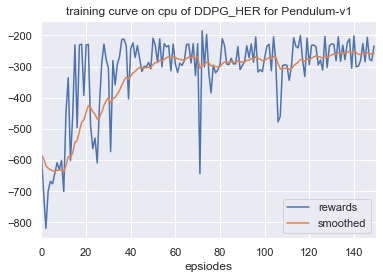

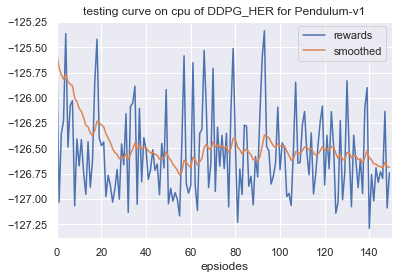

In [29]:
# 获取参数
cfg = Config() 
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], title=f"training curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  
# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], title=f"testing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")  # 画出结果